# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Package imports 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from time import perf_counter_ns
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance



In [34]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [35]:
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [37]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Text(0.5, 1.0, 'Correlation Matrix')

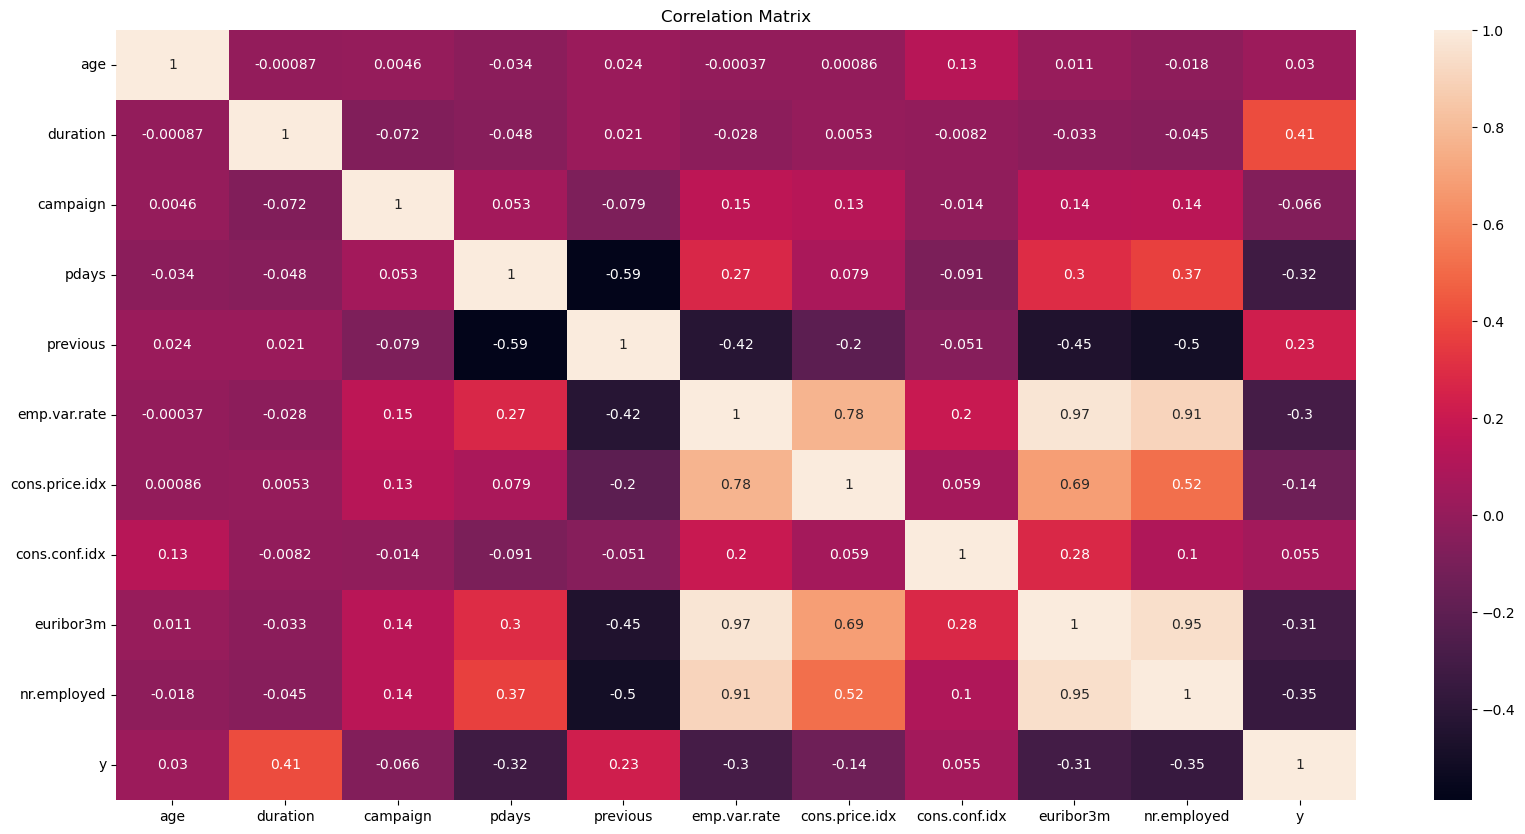

In [38]:
# Generate a correlation map 
# map the target variable to 0 and 1 
df_modified = df.copy()
df_modified['y'] = df_modified['y'].map({"no":0,"yes":1})
df_modified.head()
plt.figure(figsize=(20,10))
sns.heatmap(df_modified.corr(numeric_only=True), annot=True)

plt.title("Correlation Matrix")

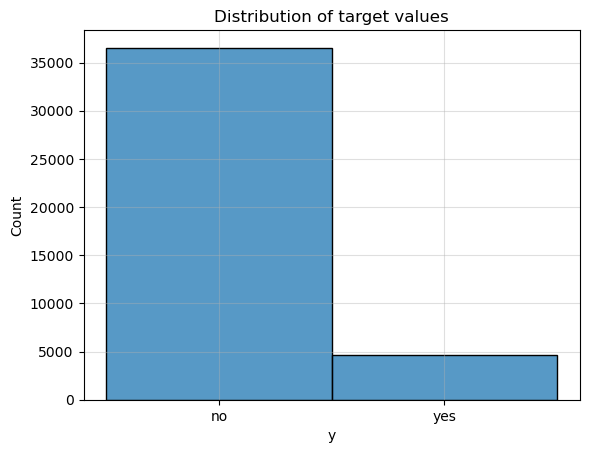

In [39]:
# Plot the distribution of target values
sns.histplot(df['y']).set_title('Distribution of target values')

# Display grid and reduce alpha (increase transparency)
plt.grid(alpha=0.4)

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [47]:
# Create a subset of the data that contains only columns 1 through 7
df_subset = df.iloc[:,1:8]

# Verify the subset of data
df_subset.head()

,job,marital,education,default,housing,loan,contact
0,housemaid,married,basic.4y,no,no,no,telephone
1,services,married,high.school,unknown,no,no,telephone
2,services,married,high.school,no,yes,no,telephone
3,admin.,married,basic.6y,no,no,no,telephone
4,services,married,high.school,no,no,yes,telephone


Using the above dataset transfor the categorical data into numerical using the OneHotEncoder pre-processor and then normalize the data using the StandardScaler preprocessor. 

In [48]:
transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), df_subset.columns),
                                     remainder = StandardScaler())

In [50]:
# dataframe with encoded/scaled values
X = transformer.fit_transform(df_subset) 
y = df['y']

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [52]:
# Create train/test split by setting the randomness to 44
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=44)

In [58]:
# Define a function that can be reused by other methods as we trrain the model 
def train(model, X_train, y_train, X_test, y_test, display_conf_matrix = True):
    # Compute the time difference of fitting the model
    start_time = perf_counter_ns()
    model.fit(X_train, y_train)
    duration = perf_counter_ns() - start_time
    
    # Generate predictions
    prediction_test = model.predict(X_test)
    
    # Calculate score for train and test data
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    # Calculates precison and recall
    precision = precision_score(y_test, prediction_test, pos_label='no')
    recall = recall_score(y_test, prediction_test, pos_label='no')
    
    # Display confusion matrix (if required)
    if (display_conf_matrix):
        ConfusionMatrixDisplay.from_predictions(y_test, prediction_test)
    
    # Return dictionary with model and results
    return {
        'model' : model, 
        'fit_duration' : duration,
        'train_score' : train_score,
        'test_score' : test_score,
        'precision' : precision,
        'recall' : recall
    }

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Lets start by creating a DummyClassifier class. This classifier serves as a simple baseline that could be used to compare against other classifiers. 

{'model': DummyClassifier(random_state=42, strategy='stratified'),
 'fit_duration': 21291708,
 'train_score': 0.8035026383088926,
 'test_score': 0.798873458288822,
 'precision': 0.8810093539264738,
 'recall': 0.8923653189379751}

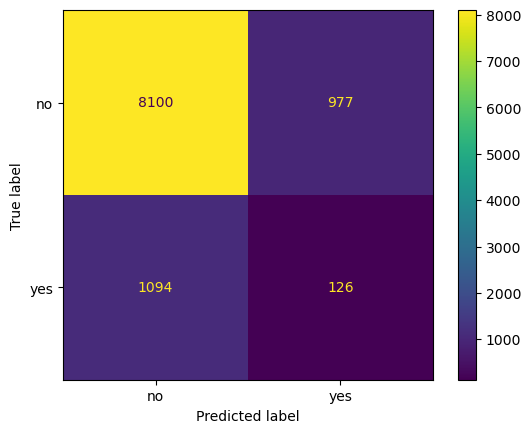

In [59]:
# Create a baseline classifier using the DummyClassifier  
dummy_classifier = train(DummyClassifier(strategy='stratified', random_state=42), X_train, y_train, X_test, y_test)

# print the classifier
dummy_classifier

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

We will be using the default settings of the Logistic Regression model adjusting the max iterations to 1500 so that the data covergence happens. 

{'model': LogisticRegression(max_iter=1500),
 'fit_duration': 152037292,
 'train_score': 0.8892881421773332,
 'test_score': 0.8815188889967952,
 'precision': 0.8815188889967952,
 'recall': 1.0}

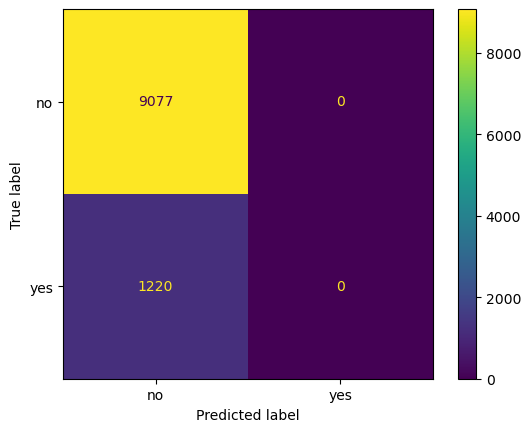

In [63]:
# Train LogisticRegression model
log_regress = train(LogisticRegression(max_iter=1500), X_train, y_train, X_test, y_test)

# Display model output
log_regress

### Problem 9: Score the Model

What is the accuracy of your model?

In [64]:
# Accuracy on the model for training data
print("Training Data Accuracy -> ", log_regress['train_score'])
# Accuracy on the model for test data
print("Test Data Accuracy -> ", log_regress['test_score'])

Training Data Accuracy ->  0.8892881421773332
Test Data Accuracy ->  0.8815188889967952


Based on the above data, we can conclude that the accuracy of this model is higher than the baseline (dummy) classifier model but the confusion matrix indicates that the model does not predict any True Positives (TP) or False Negatives (TN). Additionally, the recall=1.0 score indicates this model might be overfitted. 

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

{'model': KNeighborsClassifier(),
 'fit_duration': 35219125,
 'train_score': 0.8698326373377359,
 'test_score': 0.8549091968534525,
 'precision': 0.8822461941727997,
 'recall': 0.9640850501266939}

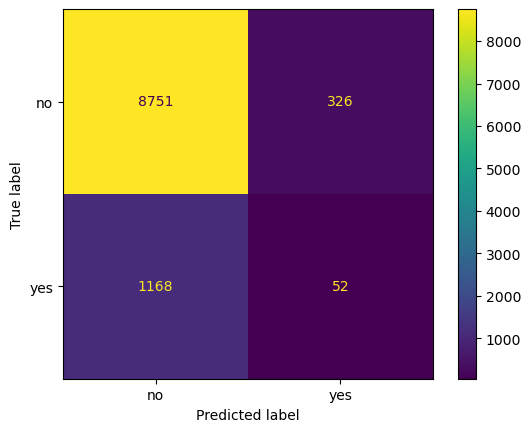

In [66]:
# Train the KNN model by calling custom function "train"
knn = train(KNeighborsClassifier(), X_train, y_train, X_test, y_test)

# Display output
knn

{'model': DecisionTreeClassifier(),
 'fit_duration': 114652167,
 'train_score': 0.8935936033148814,
 'test_score': 0.8777313780712829,
 'precision': 0.8826350822239624,
 'recall': 0.9933898865263854}

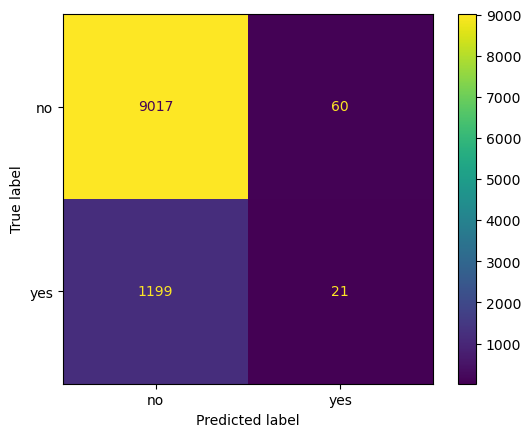

In [67]:
# Train the KNN model by calling custom function "train". Using DecisionTreeClassifier
decision_tree = train(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

# Display output
decision_tree

{'model': SVC(),
 'fit_duration': 10092731583,
 'train_score': 0.8892881421773332,
 'test_score': 0.8815188889967952,
 'precision': 0.8815188889967952,
 'recall': 1.0}

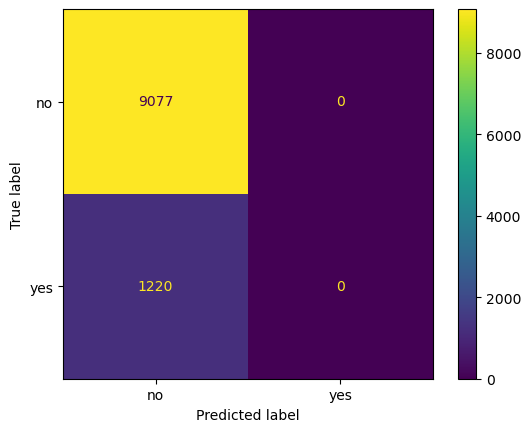

In [68]:
# Train the KNN model by calling custom function "train". Using SupportVectorModel
support_vector_model = train(SVC(), X_train, y_train, X_test, y_test)

# Display output
support_vector_model

In [69]:
# creating a results array to capture the model runs 
results = [
    ['DummyClassifier', dummy_classifier['fit_duration'], dummy_classifier['train_score'], dummy_classifier['test_score'], dummy_classifier['precision'], dummy_classifier['recall']],
    ['LogisticRegression', log_regress['fit_duration'], log_regress['train_score'], log_regress['test_score'], log_regress['precision'], log_regress['recall']],
    ['KNN', knn['fit_duration'], knn['train_score'], knn['test_score'], knn['precision'], knn['recall']],
    ['DecisionTree', decision_tree['fit_duration'], decision_tree['train_score'], decision_tree['test_score'], decision_tree['precision'], decision_tree['recall']],
    ['SVM', support_vector_model['fit_duration'], support_vector_model['train_score'], support_vector_model['test_score'], support_vector_model['precision'], support_vector_model['recall']],
]

# Summarize into a data frame  
results_df = pd.DataFrame(results, columns=['Model', 'Train Time (ns)', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall'])

results_df

,Model,Train Time (ns),Train Accuracy,Test Accuracy,Precision,Recall
0,DummyClassifier,21291708,0.803503,0.798873,0.881009,0.892365
1,LogisticRegression,152037292,0.889288,0.881519,0.881519,1.000000
2,KNN,35219125,0.869833,0.854909,0.882246,0.964085
3,DecisionTree,114652167,0.893594,0.877731,0.882635,0.993390
4,SVM,10092731583,0.889288,0.881519,0.881519,1.000000


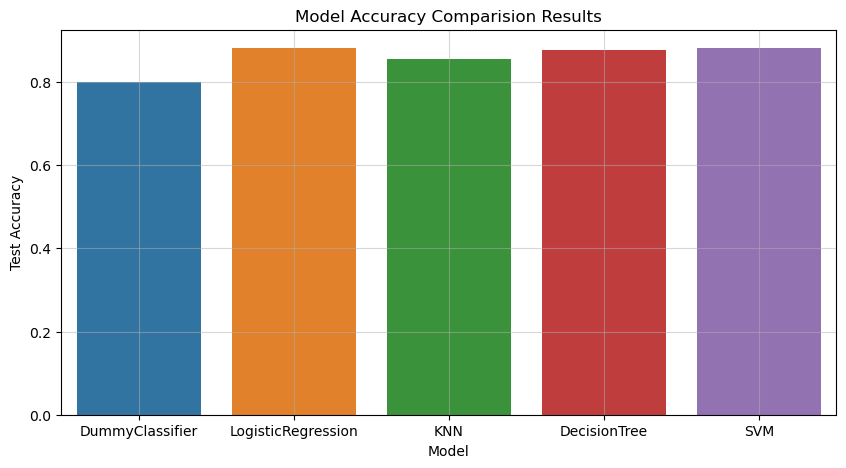

In [70]:

plt.figure(figsize=(10,5))
# Generate bar plot using Seaborn
sns.barplot(data=results_df, x='Model', y='Test Accuracy').set_title('Model Accuracy Comparision Results')
plt.grid(alpha=0.5)

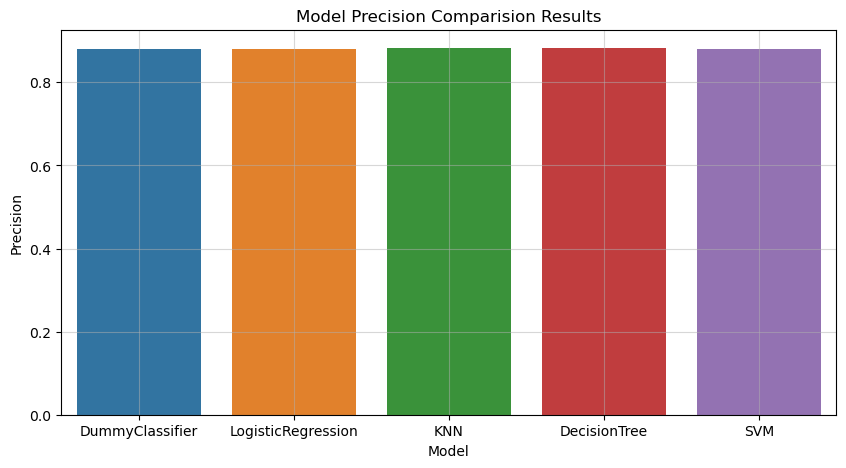

In [71]:
 
plt.figure(figsize=(10,5))
# Generate bar plot using Seaborn
sns.barplot(data=results_df, x='Model', y='Precision').set_title('Model Precision Comparision Results')
plt.grid(alpha=0.5)

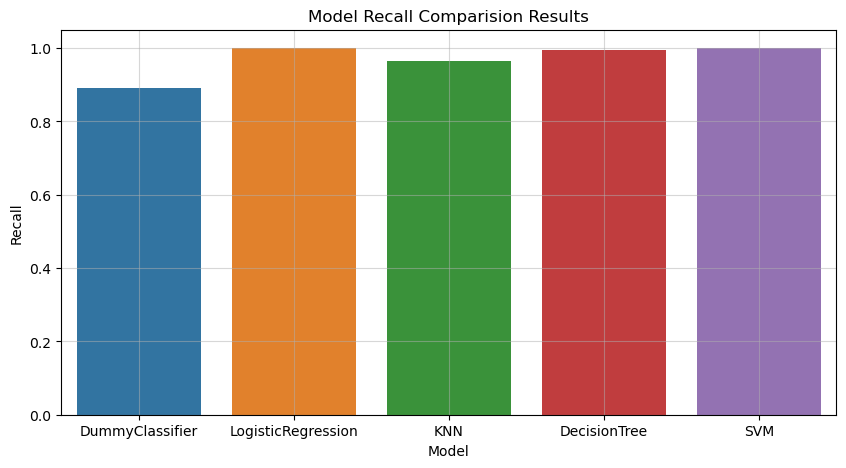

In [72]:

plt.figure(figsize=(10,5))
# Generate bar plot using Seaborn
sns.barplot(data=results_df, x='Model', y='Recall').set_title('Model Recall Comparision Results')
plt.grid(alpha=0.5)

## Observations

- LogisticRegression and SVM had the highest accuracy score with both of the being equal. KNN had the lowest score. 
- The models with the lowest precision were LogisticRegression and SVM.
- LogisticRegression and SVM had the highest recall scores.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

There are features that are potentially more relevant that others in determining the outcome of the target variable. Next step is to use the SelectFromModel feature selector to determine the most relevant features. This requires us to expand the column selection and include the categorical variables into numeric ones using the normalization process. 

In [79]:
# instantiate the selector
selector = make_column_selector(dtype_include=object)
selector

# instantiate the transformer using onehotencoder and statndard scaler   
transform_all_columns = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), selector),
    remainder=StandardScaler()
)
transform_all_columns

X_train, X_test, y_train, y_test = train_test_split(df.drop(['y'], axis = 1), df['y'], random_state = 42,
                                                   stratify = df['y'])

In [80]:
# Function that trains a pipeline and provide performance results
def train_pipeline(pipeline, X_train, y_train, X_test, y_test, show_visualizations = True):

    start_time = perf_counter_ns()
    pipeline.fit(X_train, y_train)
    duration = perf_counter_ns() - start_time
    prediction_test = pipeline.predict(X_test)
    
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)

    precision = precision_score(y_test, prediction_test, pos_label='no')
    recall = recall_score(y_test, prediction_test, pos_label='no')
    
    # Determine if visualizations need to be displayed
    if (show_visualizations):
        fig, ax = plt.subplots(1, 2, figsize = (20, 6))
        ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, ax = ax[0])
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax = ax[1])
        ax[1].plot(np.array([0, 1]), np.array([0, 1]))    
    
    # Return pipe dictionary
    return {
        'pipeline' : pipeline, 
        'fit_duration' : duration,
        'train_score' : train_score,
        'test_score' : test_score,
        'precision' : precision,
        'recall' : recall
    }

## LogisticRegression - Optimized

In [82]:
# Instantiate LogisticRegression to use Lasso regression 
logistic_regress_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter = 1000)
logistic_regress_model

LogisticRegression(max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

{'pipeline': Pipeline(steps=[('transformer',
                  ColumnTransformer(remainder=StandardScaler(),
                                    transformers=[('onehotencoder',
                                                   OneHotEncoder(drop='if_binary'),
                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x179db5110>)])),
                 ('selector',
                  SelectFromModel(estimator=LogisticRegression(max_iter=1000,
                                                               penalty='l1',
                                                               random_state=42,
                                                               solver='liblinear'))),
                 ('logistic_regression',
                  LogisticRegression(max_iter=1000, penalty='l1',
                                     random_state=42, solver='liblinear'))]),
 'fit_duration': 4846681666,
 'train_score': 0.910426985206047,
 '

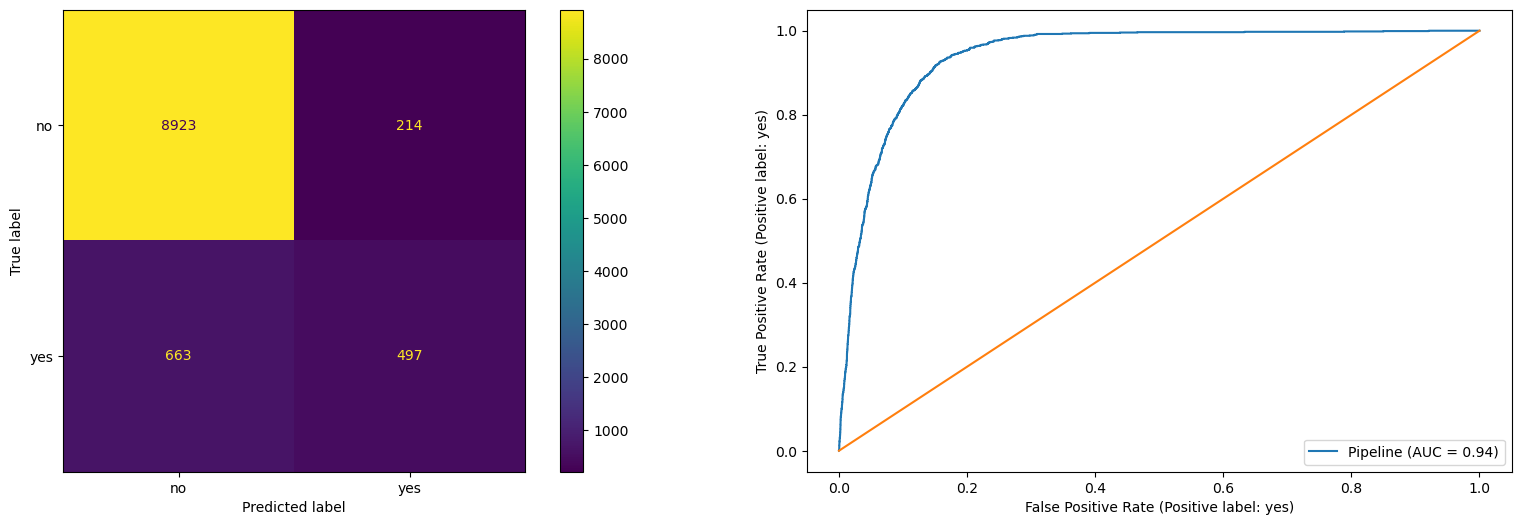

In [85]:
extractor = SelectFromModel(logistic_regress_model)
logistic_regression_pipe = train_pipeline(
    Pipeline([
        ('transformer', transform_all_columns),
        ('selector', extractor),
        ('logistic_regression', logistic_regress_model)
        
    ]), X_train, y_train, X_test, y_test)

# Genarate model output
logistic_regression_pipe

Based on the above graphs, the improved model is better than the previous basic model. The confusion metric or the recall do NOT indicate any signs of overfitting. 

In [111]:
# store the results in an array to extract 
final_results = []

# Append results from the optimized LogisticRegression with feature selector model
final_results.append(['LogisticRegression with Feature Selector', logistic_regression_pipe['fit_duration'], logistic_regression_pipe['train_score'], logistic_regression_pipe['test_score'], logistic_regression_pipe['precision'], logistic_regression_pipe['recall']])


In [112]:
# Get feature names
feature_names = logistic_regression_pipe['pipeline'].named_steps['transformer'].get_feature_names_out() 

# Instantiate variable with the selected features
selected_features =feature_names[ [int(i[1:]) for i in logistic_regression_pipe['pipeline'].named_steps['selector'].get_feature_names_out()]]

# Remove the "__" word separators added by the selector 
clean_names = [i.split('__')[-1] for i in selected_features]

# Create a dataframe with the coefficients
coef_df = pd.DataFrame({
    'feature' : clean_names,
    'coefs' : abs(logistic_regression_pipe['pipeline'].named_steps['logistic_regression'].coef_[0])
})

# Sort the order of the dataframe by the coeficient values in descending order
coef_df = coef_df.sort_values(by ='coefs', ascending = False)

# Get the latest 5 rows of the dataframe
coef_df.head()

,feature,coefs
42,emp.var.rate,2.501569
27,month_mar,1.748125
38,duration,1.206955
43,cons.price.idx,1.077669
35,poutcome_failure,0.824347


Use the permutation feature to identify the relative importance of these features. 

Text(0.5, 0, 'Feature')

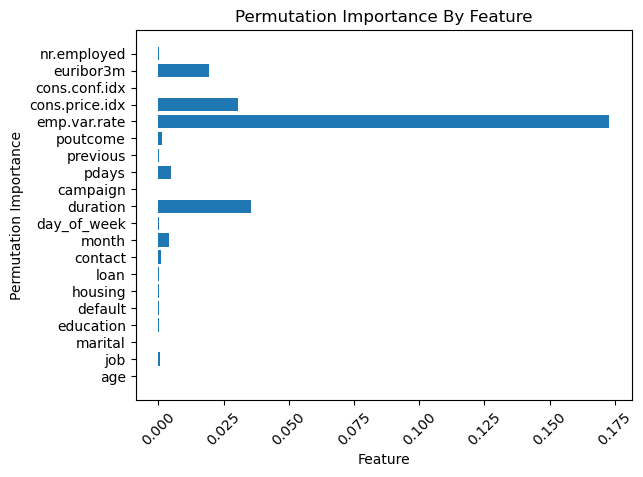

In [113]:
result = permutation_importance(logistic_regression_pipe['pipeline'], X_train, y_train, n_repeats=10,random_state=42)

# Genarate horizontal barchart to visualize results
plt.barh(y=X_train.columns.values, width=result.importances_mean)
plt.xticks(rotation=45)
plt.title("Permutation Importance By Feature")
plt.ylabel("Permutation Importance")
plt.xlabel("Feature")

Based on the above, it can be noted the most important features seem to be emp-var.rate, duration, cons.price.idx and euroibor3m. Using these we are going to train another LogisticRegression pipeline: 

{'pipeline': Pipeline(steps=[('transformer', StandardScaler()),
                 ('logistic_regression',
                  LogisticRegression(max_iter=1000, penalty='l1',
                                     random_state=42, solver='liblinear'))]),
 'fit_duration': 143942417,
 'train_score': 0.9001974685183387,
 'test_score': 0.9020102942604642,
 'precision': 0.9170771756978654,
 'recall': 0.9780015322315858}

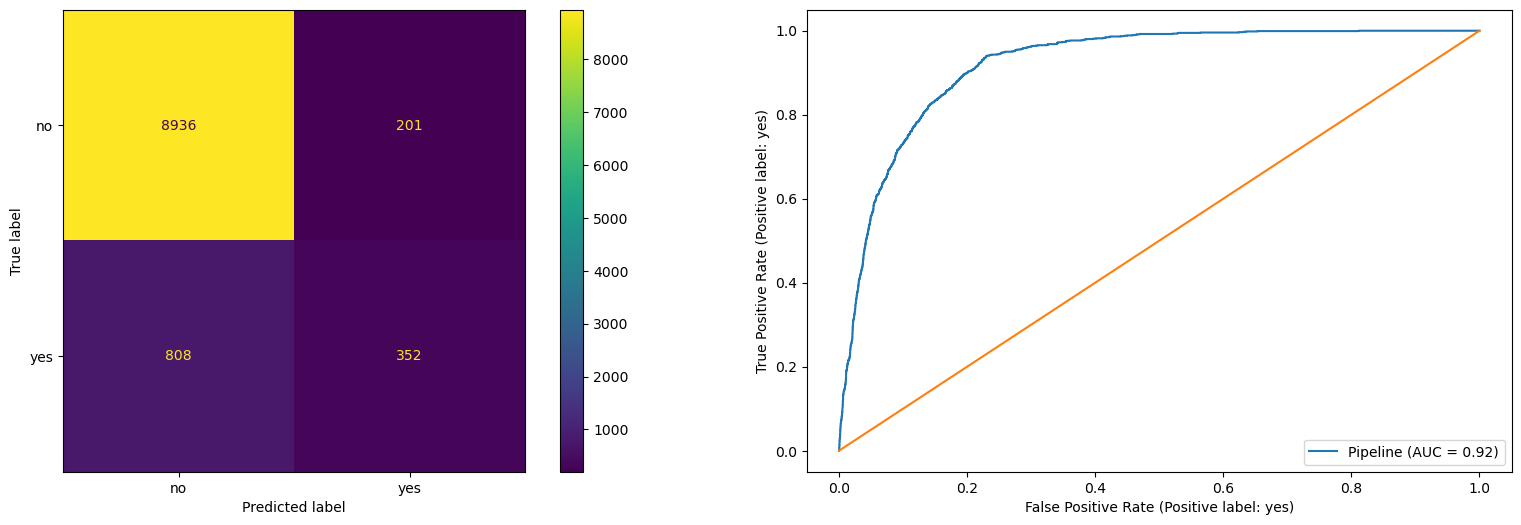

In [114]:
# Instantiate variable with selected features. 
selected_features = ['emp.var.rate', 'duration', 'cons.price.idx', 'euribor3m']

# Instantiate and train logistic regression model using only the selected features
modified_pipeline = train_pipeline(
    Pipeline([
        ('transformer', StandardScaler()),
        ('logistic_regression', lgr_model)
        
    ]), X_train[selected_features], y_train, X_test[selected_features], y_test)

# Generate model output
modified_pipeline

In [115]:
final_results.append(
    ['LogisticRegression Pipeline (permutation importance)', 
     modified_pipeline['fit_duration'],
     modified_pipeline['train_score'], 
     modified_pipeline['test_score'], 
     modified_pipeline['precision'], 
     modified_pipeline['recall']]
)

From the results obtained, we can observe a loss in performance when compared to the previous model (with the feature selector), although the recall is slighty higher on this new model.

{'pipeline': Pipeline(steps=[('transformer', StandardScaler()),
                 ('logistic_regression',
                  LogisticRegression(max_iter=1000, penalty='l1',
                                     random_state=42, solver='liblinear'))]),
 'fit_duration': 128544500,
 'train_score': 0.8870221099996762,
 'test_score': 0.8871515975526852,
 'precision': 0.8885316184351554,
 'recall': 0.9980299879610376}

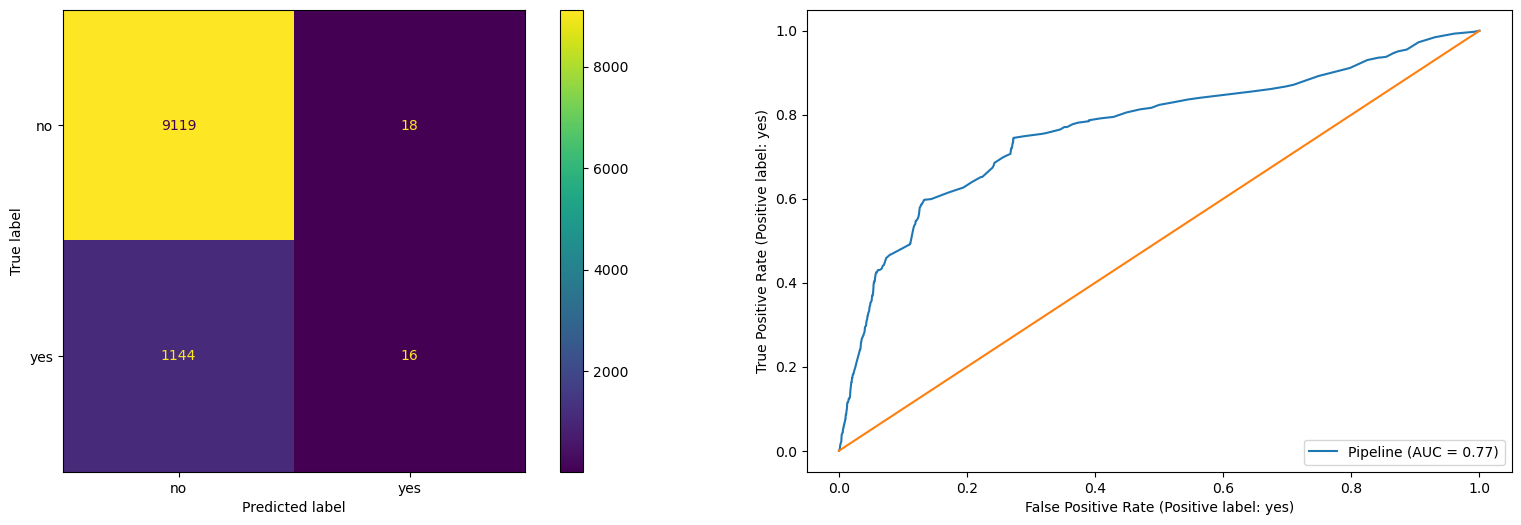

In [116]:
# Exclude duration
features_without_duration = ['emp.var.rate', 'cons.price.idx', 'euribor3m']

# Instantiate and train logistic regresion pipe
logistic_regression_pipeline_no_duration = train_pipeline(
    Pipeline([
        ('transformer', StandardScaler()),
        ('logistic_regression', lgr_model)        
    ]), X_train[features_without_duration], y_train, X_test[features_without_duration], y_test)

logistic_regression_pipeline_no_duration

The model has degraded compared to the two previous models.

In [117]:
final_results.append(
    ['LogisticRegression Pipe (no duration)', 
     logistic_regression_pipeline_no_duration['fit_duration'],
     logistic_regression_pipeline_no_duration['train_score'], 
     logistic_regression_pipeline_no_duration['test_score'], 
     logistic_regression_pipeline_no_duration['precision'], 
     logistic_regression_pipeline_no_duration['recall']]
)

final_results_df = pd.DataFrame(final_results, columns=results_df.columns)
final_results_df

,Model,Train Time (ns),Train Accuracy,Test Accuracy,Precision,Recall
0,LogisticRegression with Feature Selector,4846681666,0.910427,0.914830,0.930837,0.976579
1,LogisticRegression Pipeline (permutation impor...,143942417,0.900197,0.902010,0.917077,0.978002
2,LogisticRegression Pipe (no duration),128544500,0.887022,0.887152,0.888532,0.998030


## Conclusion

Based on the results of the analysis, it can be learned that the optimized LogisticRegression Classifier is the best model to predict is the customer will make a deposit. Further, the macroeconomic data such as Employment Variation Rate, Comsumer Price Index, Euribror 3 month rate are some of the most important features when modeling a classifier. Further analysis can be performed using GridSearch and training the models using KNN, DecisionTree and SVM. 